# Get one snapshot per month over a defined period of time, then save snapshots as .tiff

This script is partially based on: https://sentinelhub-py.readthedocs.io/en/latest/examples/process_request.html#Example-8-:-Multiple-timestamps-data

What this script does:
- Logs in to Sentinel Hub using the API credentials that can be found on your Sentinal account
- Creates a datetime interval of dates, then breaks the interval in equal deltas
- Defines an AOI (area of interest) and convert its coordinate to a bounding box
- Structure a request based on the AOI and a given timeframe
- Creates a list of requests, iterates over them and download all scenes
- Plots all images in a grid (using matplotlib)

Aditionally:
- Sets up a new MIMEtype, to download high-res TIFF
- Saves TIFF to a destination folder

### Import and configure Sentinel Hub API with credentials

In [14]:
# import config for Sentinel Hub API
from sentinelhub import SHConfig
# import personal config settings – keep them secret!
import sentinelconfig

config = SHConfig()
config.instance_id = sentinelconfig.instance
config.sh_client_id = sentinelconfig.client_ID
config.sh_client_secret = sentinelconfig.client_secret

# save current config settings
config.save()

# prompt warning if no credentials
if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [15]:
# import modules for retrieving and plotting
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np


# specific syntax for Sentinel Hub API
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

### Define time interval and monthly time windows

In [24]:
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2018, 12, 31)
n_chunks = 13
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Monthly time windows:\n")
for slot in slots:
    print(slot)

Monthly time windows:

('2018-01-01', '2018-01-29')
('2018-01-29', '2018-02-26')
('2018-02-26', '2018-03-26')
('2018-03-26', '2018-04-23')
('2018-04-23', '2018-05-21')
('2018-05-21', '2018-06-18')
('2018-06-18', '2018-07-16')
('2018-07-16', '2018-08-13')
('2018-08-13', '2018-09-10')
('2018-09-10', '2018-10-08')
('2018-10-08', '2018-11-05')
('2018-11-05', '2018-12-03')


### Get bounding box of one region and download one image from Sentinel Hub

In [17]:
# WGS84 coords for Area Of Interest (AOI)
# First the long. and lat. for the bottom left corner, then long. lat. top right corner
# Beware if you get coords from maps it's inverted!
atacama_coords_wgs84 = [-70.57, -23.95, -70.11, -23.51]

# Resolution, possible params 20, 40, 60 – the lower the par the highest the resolution
resolution = 20
# Create a bbox for your area, using coords and crs
atacama_bbox = BBox(bbox=atacama_coords_wgs84, crs=CRS.WGS84)
# Converts the resolution param into meters and provide the correct image
atacama_size = bbox_to_dimensions(atacama_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {atacama_size} pixels")


Image shape at 20 m resolution: (2322, 2458) pixels


### True color over several time windows, always the least cloudy scene

In [18]:
# Evaluation script to select the correct bands and merge them into  true color
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

In [51]:
def get_true_color_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript_moisture,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=time_interval,
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response(
            "default", MimeType.PNG)],
        bbox=atacama_bbox,
        size=atacama_size,
        config=config,
    )


In [52]:
# create a list of requests
list_of_requests = [get_true_color_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(
    list_of_requests, max_threads=5)

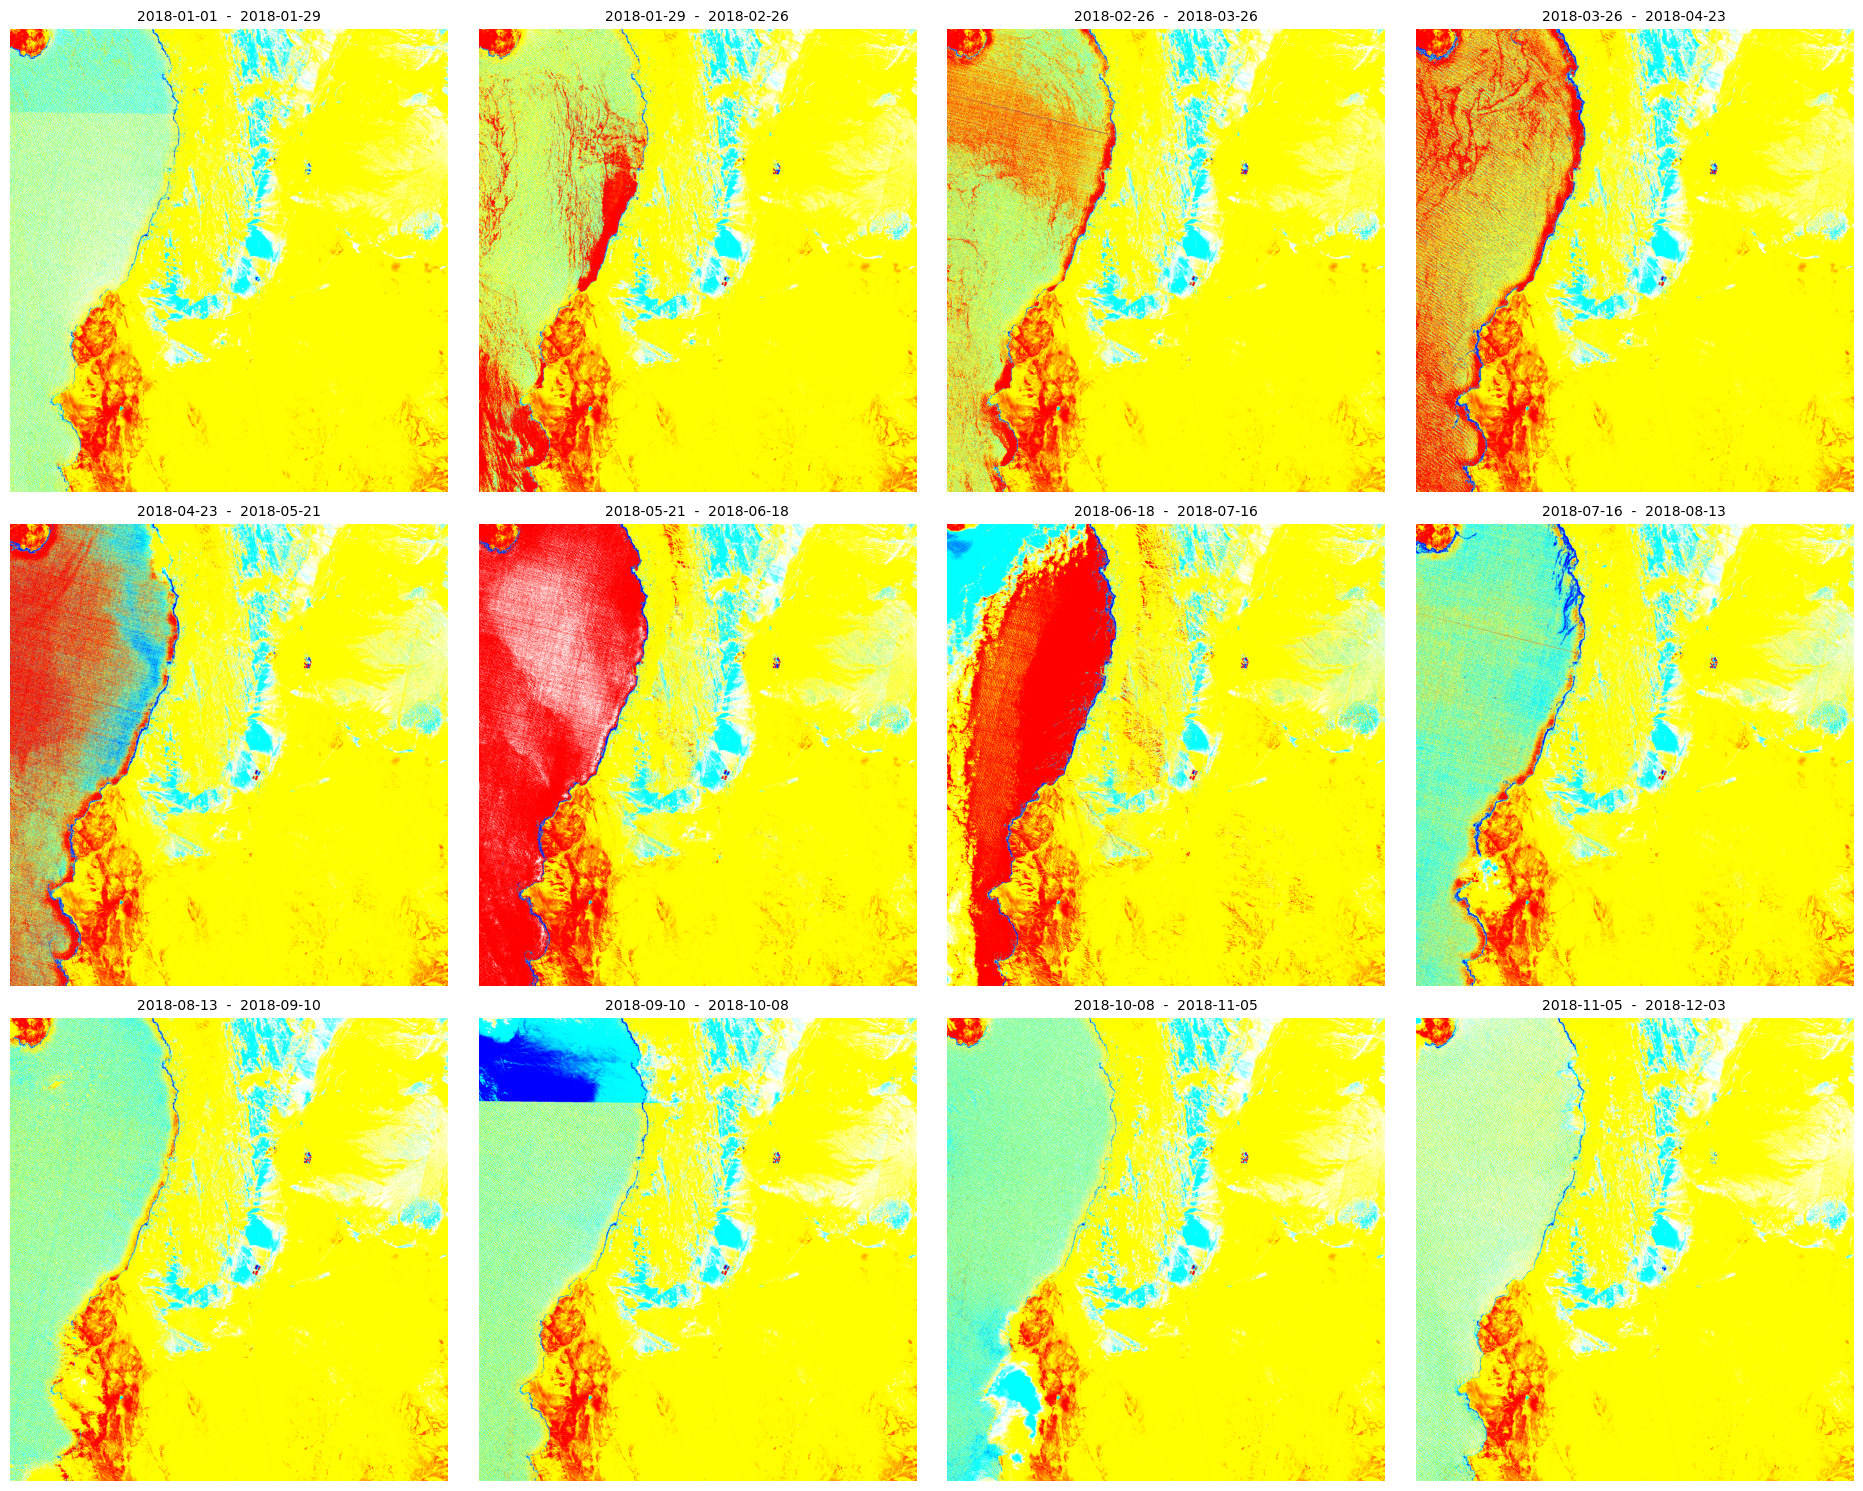

In [53]:
# some stuff for pretty plots
ncols = 4
nrows = 3
aspect_ratio = atacama_size[0] / atacama_size[1]
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(
    5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)

plt.tight_layout()


----

### Same request, but we change format and specifiy a folder to save to

In [56]:
def get_true_color_and_save_request(time_interval):
    return SentinelHubRequest(
        data_folder="request_output",
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=time_interval,
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response(
            "default", MimeType.TIFF)],
        bbox=atacama_bbox,
        size=atacama_size,
        config=config,
    )


In [57]:
%%time
# create a list of requests
list_of_requests = [get_true_color_and_save_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(
    list_of_requests, max_threads=5)


/Users/francescamorini/opt/anaconda3/envs/my_env/lib/python3.10/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/francescamorini/opt/anaconda3/envs/my_env/lib/python3.10/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


CPU times: user 3.15 s, sys: 1.29 s, total: 4.44 s
Wall time: 1min 15s


In [33]:
print(
    "The output directory has been created and a tiff file with all 13 bands was saved into the following structure:\n"
)

for folder, _, filenames in os.walk(get_true_color_and_save_request(slot).data_folder):
    for filename in filenames:
        print(os.path.join(folder, filename))


The output directory has been created and a tiff file with all 13 bands was saved into the following structure:

request_outuput/.DS_Store
request_outuput/880d0bfc7e3e432e32de4d949642fa6a/request.json
request_outuput/880d0bfc7e3e432e32de4d949642fa6a/response.tiff
request_outuput/59fa4e7ba8254f9ab975164b795c9c92/request.json
request_outuput/59fa4e7ba8254f9ab975164b795c9c92/response.tiff
request_outuput/ef14989f406bc83f5f3580dabf87a321/request.json
request_outuput/ef14989f406bc83f5f3580dabf87a321/response.tiff
request_outuput/1fee99509fe1662642cf3aa3d3f3465e/request.json
request_outuput/1fee99509fe1662642cf3aa3d3f3465e/response.tiff
request_outuput/fa7a3fca04197e66a847fa062d132bca/request.json
request_outuput/fa7a3fca04197e66a847fa062d132bca/response.tiff
request_outuput/34e77b50125341d6230054d9598a6205/request.json
request_outuput/34e77b50125341d6230054d9598a6205/response.tiff
request_outuput/5ae241460cea7f0d0815c2dc19583672/request.json
request_outuput/5ae241460cea7f0d0815c2dc19583672/

In [ ]:
evalscript_moisture = """
//VERSION=3
const moistureRamps = [
    [-0.8, 0x800000],
    [-0.24, 0xff0000],
    [-0.032, 0xffff00],
    [0.032, 0x00ffff],
    [0.24, 0x0000ff],
    [0.8, 0x000080]
  ];

const viz = new ColorRampVisualizer(moistureRamps);

function setup() {
  return {
    input: ["B8A", "B11", "SCL", "dataMask"],
    output: [
      { id: "default", bands: 4 },
      { id: "index", bands: 1, sampleType: "FLOAT32" },
      { id: "eobrowserStats", bands: 2, sampleType: "FLOAT32" },
      { id: "dataMask", bands: 1 },
    ],
  };
}

function evaluatePixel(samples) {
  let val = index(samples.B8A, samples.B11);
  // The library for tiffs works well only if there is only one channel returned.
  // So we encode the "no data" as NaN here and ignore NaNs on frontend.
  const indexVal = samples.dataMask === 1 ? val : NaN;
  return {
    default: [...viz.process(val), samples.dataMask],
    index: [indexVal],
    eobrowserStats: [val, isCloud(samples.SCL) ? 1 : 0],
    dataMask: [samples.dataMask],
  };
}

function isCloud(scl) {
  if (scl == 3) {
    // SC_CLOUD_SHADOW
    return false;
  } else if (scl == 9) {
    // SC_CLOUD_HIGH_PROBA
    return true;
  } else if (scl == 8) {
    // SC_CLOUD_MEDIUM_PROBA
    return true;
  } else if (scl == 7) {
    // SC_CLOUD_LOW_PROBA
    return false;
  } else if (scl == 10) {
    // SC_THIN_CIRRUS
    return true;
  } else if (scl == 11) {
    // SC_SNOW_ICE
    return false;
  } else if (scl == 1) {
    // SC_SATURATED_DEFECTIVE
    return false;
  } else if (scl == 2) {
    // SC_DARK_FEATURE_SHADOW
    return false;
  }
  return false;
}
"""
